In [30]:
# import pytorch and pyro; set random generator seed
import torch

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive

import matplotlib.pyplot as plt
from tqdm.notebook import trange

pyro.set_rng_seed(101)

# to clear all variables stored by Pyro
pyro.clear_param_store()

# enable validation for useful warnings and errors
pyro.enable_validation(True)


----
Homework
-------




1. Prepare a Pyro model function, which will express the number of buses arriving and the bus stop in an hour. Assume [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) of the number of arrivals in per hour:

   $$N \sim Pois\left(\lambda\right)$$

   where $\lambda$ is set using a function:
   
   $$\lambda = \left\{\begin{array}{c} 2 + 2 * \sin\left(\frac{\pi}{16}\left(t - 8\right)\right),\; t \in \left[8, 24\right]  \\ 1,\; t \notin \left[8, 24\right] \end{array}\right.$$
   
   Where $t$ is hour of the day. Use the function from the cell below.
   
   For each hour print 3 sampels of bus arrivals. 


In [25]:
from math import sin, pi
  
def bus_arrival(hour):
   
    if hour < 8 or hour > 24:
        lambd = 1
    else:
        lambd =2+2*sin((pi/16)*(hour-8))
    with pyro.plate("data", 3) as ind:
        return pyro.sample("bus_per_hour",dist.Poisson(lambd))

In [32]:
for i in range(24):
    print(bus_arrival(i).mean())

tensor(1.3333)
tensor(0.6667)
tensor(0.3333)
tensor(1.3333)
tensor(0.3333)
tensor(0.6667)
tensor(0.3333)
tensor(0.6667)
tensor(1.6667)
tensor(2.3333)
tensor(1.6667)
tensor(3.3333)
tensor(3.3333)
tensor(2.6667)
tensor(3.6667)
tensor(3.3333)
tensor(2.6667)
tensor(4.3333)
tensor(4.6667)
tensor(3.6667)
tensor(4.3333)
tensor(4.)
tensor(2.)
tensor(4.)


2. Prepare a simpler guide, that will try to approximate `bus_arrival()` using only Poisson distribution (with $\lambda$ as a param).

$$N_{approx} \sim Pois\left(\lambda\right)$$

   Train the model for hour 14.00 (`hour = 14.00`) and display how both params vary.


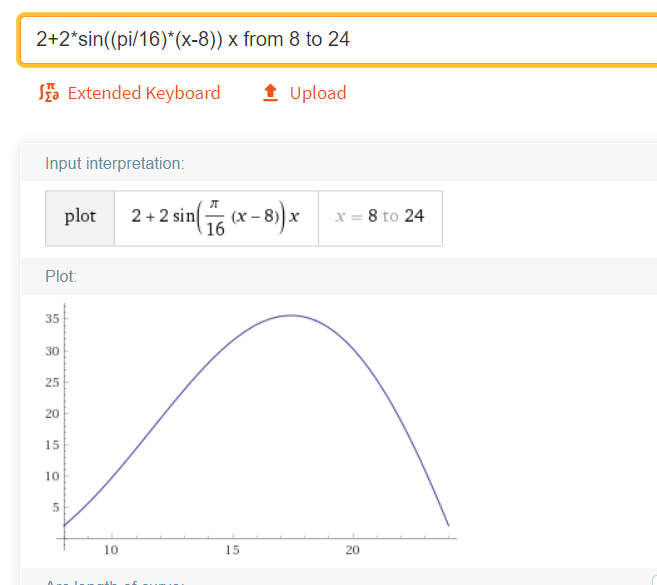

In [40]:
from torch.distributions import constraints
def bus_arrival_guide(t):
    param_value = 1 # i picked random value
    param = pyro.param("rate", torch.tensor(param_value), constraint=constraints.positive)
    with pyro.plate("data", 3) as ind:
        return pyro.sample("bus_per_hour",dist.Poisson(param))


rate = 3.8477566242218018


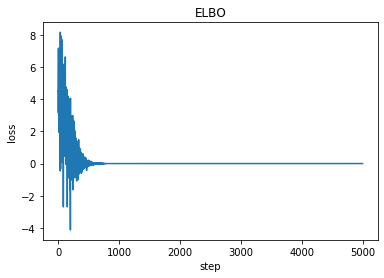

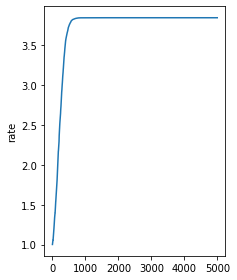

In [41]:
lr = 1e-3
n_steps = 5000
hour = 14.0

pyro.clear_param_store()
svi = pyro.infer.SVI(model = bus_arrival,
                     guide = bus_arrival_guide,
                     optim=pyro.optim.SGD({"lr": lr}),
                     loss=pyro.infer.Trace_ELBO())


losses, rates = [], []
# write the training loop

for t in trange(n_steps):
    losses.append(svi.step(hour))
    rates.append(pyro.param("rate").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
print(f"rate = {pyro.param('rate').item()}")
plt.show()

plt.subplot(1,2,1)
plt.plot(rates)
plt.ylabel('rate')
plt.tight_layout()
plt.show()
